# Importing and cleaning the data

I downloaded the data from the [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/) from ai.stanford.edu.

Citation:
Maas, A., Daly, R., Pham, P., Huang, D., Ng, A., & Potts, C. (2011). Learning Word Vectors for Sentiment Analysis. In Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies (pp. 142–150). Association for Computational Linguistics.

The data is in the form of .txt files, with one review per file. These files are in the following directories:
```
data/aclImdb/{train or test}/{pos or neg}
```
### Data cleaning
The name of each file gives the index of the file, together with the rating, from 1 to 10, as follows:
```
{index}_{rating}.txt
```
First I want to add leading zeros to the filenames, so that the alphabetical order is the same as the index number order.

In [3]:
import os

dirs = ['data/aclImdb/train/pos', 'data/aclImdb/train/neg', 'data/aclImdb/test/pos', 'data/aclImdb/test/neg']
for dir in dirs:
    for dir_file in os.listdir(dir):
            file_number, file_end = dir_file.split('_')
            num = file_number.zfill(5)  # num is 5 characters long with leading 0

            
            new_file = "{}_{}".format(num, file_end)
            os.rename(dir + '/' + dir_file, dir + '/' + new_file)

When importing the files I found that some had a unicode character that caused a line break. This would cause these files to be imported as two (or more) separate data rows, when I wanted the whole file to be imported as one row. So I removed this unicode character from all files.

In [4]:
dirs = ['data/aclImdb/train/pos', 'data/aclImdb/train/neg', 'data/aclImdb/test/pos', 'data/aclImdb/test/neg']
for dir in dirs:
    for dir_file in os.listdir(dir):
        # Read in the file
        with open(dir + '/' + dir_file, 'r') as file:
            filedata = file.read()
        # Replace the target string
        filedata = filedata.replace('\u0085', ' ')

        # Write the file out again
        with open(dir + '/' + dir_file, 'w') as file:
            file.write(filedata)

I then wanted to extract the rating from each filename into a list.

In [5]:
# Put the files into ordered lists, one for train and one for test
dirs = ['train','test']
files = {}
ratings = {}
for dir in dirs:
    files[dir] = []
    ratings[dir] = []
    subdirs = ['pos', 'neg']
    for subdir in subdirs:
        files_tmp = []
        for dir_file in os.listdir('data/aclImdb/' + dir + '/' + subdir):
            files_tmp += [dir_file]
        files_tmp = sorted(files_tmp)
        files[dir].extend(files_tmp)
    for file in files[dir]:
        rating = int(file.split('_')[1].split('.')[0])
        ratings[dir].append(rating)

I now have two lists:
```ratings['train']```
and
```ratings['test']```
which are each of length 25,000, containing the ratings for the train and test reviews, in index order.

In [57]:
train_ratings = np.array(ratings['train'])

# Data Analysis

### Distribution of Ratings

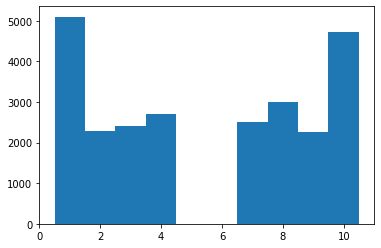

In [52]:
import matplotlib.pyplot as plt
import numpy as np

data = train_ratings
d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
plt.show()

Note that there are no 5 or 6 ratings. This is because the dataset was prepared for the intention of sentiment analysis, and split into positive (ratings 7 to 10) and negative (ratings 1 to 4). Ideally our data would include a full range of ratings, but I think the model will still be able to train well without the mid-range ratings.

### Baseline MSE
Our metric for the model will be Mean Squared Error, which will give us a measure of how far each prediction is from the actual rating. It returns the sum of the squares of the differences between the predictions and the actual ratings.

It will be helpful for us to have a baseline for what this MSE would be with a very naive model. One very simple baseline is to take the mean of all ratings, and predict this mean each time. This would give the following MSE:

In [76]:
import statistics

mean = statistics.fmean(train_ratings)
mse = statistics.mean((train_ratings - mean)**2)
mse

12.0159836016

If our model is finding any signal in the data, it should be going lower than this baseline MSE.

### Optimal MSE
I imagine that predicting ratings from reviews will have an optimal MSE that is significantly higher than 0. Even a highly experienced group of human experts will not be able to approach perfect predicting, because the ratings given by the reviewers have a certain level of inherent unpredictability. Someone may review a movie as "This was awesome" and give it a rating of 10, while someone else could give exactly the same review with a rating of 7.

So I am expecting that the [Bayes error](https://en.wikipedia.org/wiki/Bayes_error_rate) is significantly above zero. My guess is it might be somewhere in the region of an MSE of 4, meaning that the average prediction is wrong by two ratings points. But that is only a guess based on my intution of how much unpredictability there is in the ratings that reviewers assign.

### Length of reviews

In [42]:
dirs = ['data/aclImdb/train/pos', 'data/aclImdb/train/neg', 'data/aclImdb/test/pos', 'data/aclImdb/test/neg']
lengths_chars = []
lengths_words = []
for dir in dirs:
    for dir_file in os.listdir(dir):
        # Read in the file
        with open(dir + '/' + dir_file, 'r') as file:
            filedata = file.read()
            length_chars = len(filedata)
            length_words = len(filedata.split())
            lengths_chars.append(length_chars)
            lengths_words.append(length_words)

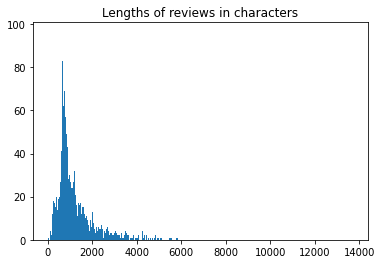

In [45]:
data = lengths_chars
data = np.array(data)

d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
plt.title('Lengths of reviews in characters')
plt.show()

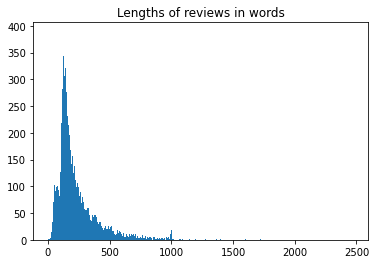

In [46]:
data = lengths_words
data = np.array(data)

d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
plt.title('Lengths of reviews in words')
plt.show()

We see that most reviews are under 512 words. This is good, since the tokenizer that we will use has a maximum length of 512 words, meaning that any words after this limit will be ignored by the model.

# Preparing the data for batch training

The text data are still in ```.txt``` files in four directories:
```
train/pos
train/neg
test/pos
test/neg
```
These can be converted into a Dataset, that the pretrained NLP model can efficiently process in batches.

In [47]:
from datasets import load_dataset

data = load_dataset("text", data_files={'train': ['data/aclImdb/train/pos/*.txt', 'data/aclImdb/train/neg/*.txt'], 'test': ['data/aclImdb/test/pos/*.txt', 'data/aclImdb/test/neg/*.txt']})

Resolving data files:   0%|          | 0/25000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/25000 [00:00<?, ?it/s]

Using custom data configuration default-208475e3491f36cc


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset text downloaded and prepared to /home/mark/.cache/huggingface/datasets/text/default-208475e3491f36cc/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

NLP models can be very expensive to train, often involving a GPU running for long periods of time. So when setting up the training, and even when tuning hyperparameters, I want to have the option to do this on a subset of the data to speed up the process.

I will define a function to return a subset of the dataset, with a given number of rows, but ensuring that this subset includes rows from both the positive and negative parts of the data.

In [78]:
def data_subset(data, max_rows):
    return data.filter(lambda e, i: (i in range(int(max_rows / 2)) or i in range(int(len(data['train']) / 2), int(len(data['train']) / 2) + int(max_rows / 2))), with_indices=True)

### Save the data to Amazon S3
I next saved the data to Amazon S3 storage, where it could be accessed from elsewhere as I trained the model.

In [ ]:
!mkdir -p ~/.aws
!cp ./aws_config ~/.aws/config

In [ ]:
from botocore.session import Session

s3_session = Session()
s3 = datasets.filesystems.S3FileSystem(session=s3_session)
data.save_to_disk('s3://mlzoomcamp-capstone', fs=s3)

# Base Model and Tokenizer
Since training an NLP model from scratch requires a huge amount of time and computing resources, I will use a base transformer model to process the text data. I will then add my own custom layers on top of the base model, and train these custom layers on the target data - the ratings.

I decided to use DistilBert as the base transformer. According to its [Hugging Face model card](https://huggingface.co/docs/transformers/model_doc/distilbert), DistilBERT is "a small, fast, cheap and light Transformer model trained by distilling BERT base". Specifically I will use the "distilbert-base-uncased" model, which is a base model (designed to be finetuned for various tasks) that is uncased (meaning that it does not distinguish between upper and lower case).

In [80]:
checkpoint = 'distilbert-base-uncased'

In order to be inputted into the Transformer model, the data needs to be processed by a tokenizer. The tokenizer takes the words and basically assigns an integer to each word. This tokenizer is defined by the Transformer model, so it is important that we use the tokenizer for the particular model that we will use.

In [28]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

I want to truncate the data (discarding words after the ```max_length``` has been reached) and add padding (zeros) up until the ```max_length```. This ```max_length``` is the maximum number of words from the text that will be inputted into the model. This is a hyperparameter that I will tune, up to the maximum value of 512 which is the maximum length that ```distilbert-base-uncased``` can read.

In [79]:
def tokenize_function(data):
    return tokenizer(data["text"], truncation=True, padding=True, max_length=params['max_length'])

The ```data_collator``` function will take this tokenized data and return tensorflow tensors, which are the format that the base model expects as input.

In [29]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

I have defined a single ```prepare_data()``` function below, that takes the hyperparameters as input and returns the tensorflow tensors that can be inputted into the model.

I am using the 25,000 ```train``` reviews as training data and the 25,000 ```test``` reviews as validation data. 

In [114]:
def prepare_data(params):
    max_rows = params['max_rows']
    max_length = params['max_length']
    smaller_data = data.filter(lambda e, i: (i in range(int(max_rows / 2)) or i in range(12500, 12500 + int(max_rows / 2))), with_indices=True)
    tokenized_data = smaller_data.map(tokenize_function, batched=True)
    print(tokenized_data['train'])
    
    tf_train_dataset = tokenized_data["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["rating"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=params['batch_size'],
        )
    tf_val_dataset = tokenized_data["test"].to_tf_dataset(
        columns=["attention_mask", "input_ids"],
        label_cols=["rating"],
        shuffle=True,
        collate_fn=data_collator,
        batch_size=params['batch_size'],
        )
    return tf_train_dataset, tf_val_dataset

The function ```config_model``` again takes the various hyperparameters from ```params``` and configures the base model accordingly. It also sets the base layers as not trainable, since I don't want to train the base model - I only want to train the custom layers that I am adding.

The following two functions were mostly copied from [this post](https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379) from Towards Data Science.

In [115]:
def config_model(params):
 
    # Configure DistilBERT's initialization
    config = DistilBertConfig(dropout=params['layer_dropout'] , 
                              attention_dropout=params['att_dropout'], 
                              output_hidden_states=True)

    # The bare, pre-trained DistilBERT transformer model outputting raw hidden-states 
    # and without any specific head on top.
    distilBERT = TFDistilBertModel.from_pretrained(checkpoint, config=config)

    # Make DistilBERT layers untrainable
    for layer in distilBERT.layers:
        layer.trainable = False
    return distilBERT

The function ```build_model()``` takes this base transformer model as an input, along with the hyperparameters ```params``` and adds the following customs layers:

* A GlobalAvgPool1D layer to reduce the dimension to a single vector
* A 128-unit dense layer, with RELU activation
* A 128-unit dense layer, with RELU activation
* A 64-unit dense layer, with RELU activation
* A 10-unit dense layer, with RELU activation
* A 1-unit dense layer, with no activation, to output the single rating prediction

I did not have time to systematically vary this architecture, so I made a few trial and error assessments, and went with this. If I had more time, tuning this architecture would be the next thing I would focus on.

In [116]:
def build_model(transformer, params):
    """
    Template for building a model off of the BERT or DistilBERT architecture
    for a binary classification task.
    
    Input:
      - transformer:  a base Hugging Face transformer model object (BERT or DistilBERT)
                      with no added classification head attached.
      - max_length:   integer controlling the maximum number of encoded tokens 
                      in a given sequence.
    
    Output:
      - model:        a compiled tf.keras.Model with added classification layers 
                      on top of the base pre-trained model architecture.
    """
    
    # Define weight initializer with a random seed to ensure reproducibility
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=RANDOM_STATE) 
    
    # Define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(params['max_length'],), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(params['max_length'],), 
                                                  name='attention_mask', 
                                                  dtype='int32')
    
    # DistilBERT outputs a tuple where the first element at index 0
    # represents the hidden-state at the output of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    
    # We only care about DistilBERT's output for the [CLS] token, 
    # which is located at index 0 of every encoded sequence.  
    # Splicing out the [CLS] tokens gives us 2D data.
    # cls_token = last_hidden_state[:, 0, :]
    
    ##                                                 ##
    ## Define additional dropout and dense layers here ##
    ##                                            
    
    # vector = tf.reshape(last_hidden_state, [-1])

    vector = tf.keras.layers.GlobalAvgPool1D()(last_hidden_state)

    output1 = tf.keras.layers.Dense(128, 
                                   activation='relu',
                                   kernel_initializer=weight_initializer,  
                                   kernel_constraint=None,
                                   bias_initializer='zeros'
                                   )(vector)
    
    output2 = tf.keras.layers.Dense(128, 
                                   activation='relu',
                                   kernel_initializer=weight_initializer,  
                                   kernel_constraint=None,
                                   bias_initializer='zeros'
                                   )(output1)
    
    output3 = tf.keras.layers.Dense(64, 
                                   activation='relu',
                                   kernel_initializer=weight_initializer,  
                                   kernel_constraint=None,
                                   bias_initializer='zeros'
                                   )(output2)

    output4 = tf.keras.layers.Dense(10, 
                                   activation='relu',
                                   kernel_initializer=weight_initializer,  
                                   kernel_constraint=None,
                                   bias_initializer='zeros'
                                   )(output3)
    
    # Define a single node that makes up the output layer (for binary classification)
    output5 = tf.keras.layers.Dense(1, 
                                   activation=None,
                                   kernel_initializer=weight_initializer,  
                                   kernel_constraint=None,
                                   bias_initializer='zeros'
                                   )(output4)
    
    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output5)
    
    # Compile the model
    model.compile(tf.keras.optimizers.Adam(learning_rate=params['lr']), 
                  loss=MeanSquaredError(),
                  metrics=['mse'])
    
    return model

In [117]:
distilBERT = config_model(params)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [118]:
model = build_model(distilBERT, params)

In [119]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 512, 768),                                                   
                                 hidden_states=((No                                         

# Model Training
As I do not have a GPU on my local machine, at this point I moved over to Kaggle to train the model:

*** Insert Kaggle link